In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("data_regime/nifty_with_regime_fixed_5min.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print(df.shape)
df.head()

(4112, 48)


,timestamp,open,high,low,close,volume,fut_open,fut_high,fut_low,fut_close,...,rho_put,avg_iv,iv_spread,delta_neutral_ratio,gamma_exposure_call,gamma_exposure_put,spot_returns,state,regime,regime_fixed
0,2025-10-29 09:20:00+05:30,25980.55,25992.50,25968.40,25988.55,0,26457.4,26474.1,26457.4,26458.5,...,-2.514500,0.744856,0.705429,1.101704,2.575267e+06,1.077917e+07,0.000339,1,1,1
1,2025-10-29 09:25:00+05:30,25990.30,26016.85,25988.15,26010.00,0,26458.5,26499.0,26458.5,26494.0,...,-2.475707,0.735631,0.744060,1.121058,2.548710e+06,1.162033e+07,0.000825,1,1,1
2,2025-10-29 09:30:00+05:30,26010.75,26025.05,25996.30,25996.35,0,26494.0,26500.0,26492.0,26492.0,...,-2.495090,0.734716,0.752480,1.108689,2.548608e+06,1.178650e+07,-0.000525,1,1,-1
3,2025-10-29 09:35:00+05:30,25996.90,25996.90,25963.20,25965.20,0,26492.0,26492.0,26460.0,26464.5,...,-2.466508,0.736356,0.724437,1.125181,2.576955e+06,1.130442e+07,-0.001198,1,1,-1
4,2025-10-29 09:40:00+05:30,25965.70,25975.25,25960.30,25972.30,0,26464.5,26474.2,26460.0,26470.1,...,-2.456710,0.733522,0.714988,1.131253,2.595596e+06,1.124427e+07,0.000273,1,1,0


In [2]:
need_cols = ["timestamp", "open", "close", "ema_5", "ema_15", "regime_fixed"]

missing = [c for c in need_cols if c not in df.columns]
print("Missing columns:", missing)

df[need_cols].head()

Missing columns: []


,timestamp,open,close,ema_5,ema_15,regime_fixed
0,2025-10-29 09:20:00+05:30,25980.55,25988.55,25982.683333,25980.850000,1
1,2025-10-29 09:25:00+05:30,25990.30,26010.00,25991.788889,25984.493750,1
2,2025-10-29 09:30:00+05:30,26010.75,25996.35,25993.309259,25985.975781,-1
3,2025-10-29 09:35:00+05:30,25996.90,25965.20,25983.939506,25983.378809,-1
4,2025-10-29 09:40:00+05:30,25965.70,25972.30,25980.059671,25981.993958,0


In [3]:
df["prev_ema5"] = df["ema_5"].shift(1)
df["prev_ema15"] = df["ema_15"].shift(1)

df["cross_up"] = (df["prev_ema5"] <= df["prev_ema15"]) & (df["ema_5"] > df["ema_15"])
df["cross_down"] = (df["prev_ema5"] >= df["prev_ema15"]) & (df["ema_5"] < df["ema_15"])

print("Cross Up:", df["cross_up"].sum())
print("Cross Down:", df["cross_down"].sum())

Cross Up: 143
Cross Down: 144


In [4]:
df["signal"] = 0

# LONG entry signal
df.loc[df["cross_up"] & (df["regime_fixed"] == 1), "signal"] = 1

# SHORT entry signal
df.loc[df["cross_down"] & (df["regime_fixed"] == -1), "signal"] = -1

df["signal"].value_counts()

signal
 0    3920
-1      98
 1      94
Name: count, dtype: int64

In [5]:
df["position"] = 0

pos = 0
for i in range(1, len(df)):
    # exit rules
    if pos == 1 and df.loc[i, "cross_down"]:
        pos = 0
    elif pos == -1 and df.loc[i, "cross_up"]:
        pos = 0

    # entry rules (only when flat)
    if pos == 0:
        if df.loc[i, "signal"] == 1:
            pos = 1
        elif df.loc[i, "signal"] == -1:
            pos = -1

    # no trades in regime 0 (force flat)
    if df.loc[i, "regime_fixed"] == 0:
        pos = 0

    df.loc[i, "position"] = pos

df["position"].value_counts()

position
 0    3740
-1     192
 1     180
Name: count, dtype: int64

In [6]:
df["position_exec"] = df["position"].shift(1).fillna(0)

In [7]:
df["open_next"] = df["open"].shift(-1)
df["ret_open"] = (df["open_next"] - df["open"]) / df["open"]

df["strategy_ret"] = df["position_exec"] * df["ret_open"]
df["equity"] = (1 + df["strategy_ret"].fillna(0)).cumprod()

df[["timestamp","open","position_exec","ret_open","strategy_ret","equity"]].head(10)

,timestamp,open,position_exec,ret_open,strategy_ret,equity
0,2025-10-29 09:20:00+05:30,25980.55,0.0,0.000375,0.000000,1.000000
1,2025-10-29 09:25:00+05:30,25990.30,0.0,0.000787,0.000000,1.000000
2,2025-10-29 09:30:00+05:30,26010.75,0.0,-0.000532,-0.000000,1.000000
3,2025-10-29 09:35:00+05:30,25996.90,0.0,-0.001200,-0.000000,1.000000
4,2025-10-29 09:40:00+05:30,25965.70,0.0,0.000187,0.000000,1.000000
5,2025-10-29 09:45:00+05:30,25970.55,0.0,-0.000092,-0.000000,1.000000
6,2025-10-29 09:50:00+05:30,25968.15,0.0,0.000780,0.000000,1.000000
7,2025-10-29 09:55:00+05:30,25988.40,0.0,-0.000185,-0.000000,1.000000
8,2025-10-29 10:00:00+05:30,25983.60,0.0,0.000477,0.000000,1.000000
9,2025-10-29 10:05:00+05:30,25996.00,1.0,0.000069,0.000069,1.000069


In [8]:
split = int(len(df) * 0.70)

train_df = df.iloc[:split].copy()
test_df  = df.iloc[split:].copy()

print("Train rows:", train_df.shape)
print("Test rows :", test_df.shape)

Train rows: (2878, 59)
Test rows : (1234, 59)


In [9]:
def max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    dd = (equity_curve / peak) - 1
    return dd.min()

def sharpe_ratio(returns, periods_per_year=252*75):  
    # 5-min candles per day ≈ 75 (9:15 to 15:30)
    r = returns.dropna()
    if r.std() == 0:
        return 0
    return (r.mean() / r.std()) * np.sqrt(periods_per_year)

def sortino_ratio(returns, periods_per_year=252*75):
    r = returns.dropna()
    downside = r[r < 0]
    if downside.std() == 0:
        return 0
    return (r.mean() / downside.std()) * np.sqrt(periods_per_year)

def calmar_ratio(equity_curve, periods_per_year=252*75):
    total_return = equity_curve.iloc[-1] - 1
    mdd = abs(max_drawdown(equity_curve))
    if mdd == 0:
        return 0
    return total_return / mdd

def profit_factor(returns):
    gains = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    if losses == 0:
        return np.inf
    return gains / losses

In [10]:
def extract_trades(df):
    trades = []
    pos = 0
    entry_idx = None
    entry_price = None

    for i in range(len(df)-1):
        p = df["position_exec"].iloc[i]
        next_open = df["open"].iloc[i+1]

        # entry
        if pos == 0 and p != 0:
            pos = p
            entry_idx = i+1
            entry_price = next_open

        # exit
        if pos != 0 and p == 0:
            exit_idx = i+1
            exit_price = next_open

            pnl = (exit_price - entry_price) / entry_price
            if pos == -1:
                pnl = -pnl

            trades.append({
                "side": "LONG" if pos == 1 else "SHORT",
                "entry_time": df["timestamp"].iloc[entry_idx],
                "exit_time": df["timestamp"].iloc[exit_idx],
                "entry_price": entry_price,
                "exit_price": exit_price,
                "pnl_pct": pnl,
                "duration_bars": exit_idx - entry_idx
            })

            pos = 0
            entry_idx = None
            entry_price = None

    return pd.DataFrame(trades)

In [11]:
def compute_metrics(df_part, name=""):
    eq = (1 + df_part["strategy_ret"].fillna(0)).cumprod()
    ret = df_part["strategy_ret"].fillna(0)

    trades = extract_trades(df_part)

    total_return = eq.iloc[-1] - 1
    mdd = max_drawdown(eq)

    metrics = {
        "Dataset": name,
        "Total Return %": round(total_return*100, 2),
        "Sharpe": round(sharpe_ratio(ret), 3),
        "Sortino": round(sortino_ratio(ret), 3),
        "Calmar": round(calmar_ratio(eq), 3),
        "Max Drawdown %": round(mdd*100, 2),
        "Total Trades": int(len(trades)),
    }

    if len(trades) > 0:
        win_rate = (trades["pnl_pct"] > 0).mean()
        metrics["Win Rate %"] = round(win_rate*100, 2)
        metrics["Profit Factor"] = round(profit_factor(trades["pnl_pct"]), 3)
        metrics["Avg Trade Duration (bars)"] = round(trades["duration_bars"].mean(), 2)
    else:
        metrics["Win Rate %"] = 0
        metrics["Profit Factor"] = 0
        metrics["Avg Trade Duration (bars)"] = 0

    return metrics, trades

In [12]:
train_metrics, train_trades = compute_metrics(train_df, "TRAIN (70%)")
test_metrics, test_trades = compute_metrics(test_df, "TEST (30%)")

results = pd.DataFrame([train_metrics, test_metrics])
results

,Dataset,Total Return %,Sharpe,Sortino,Calmar,Max Drawdown %,Total Trades,Win Rate %,Profit Factor,Avg Trade Duration (bars)
0,TRAIN (70%),1.50,3.789,1.565,2.995,-0.50,118,46.61,0.970,2.17
1,TEST (30%),1.03,5.650,3.069,2.751,-0.37,49,53.06,1.484,2.35


In [13]:
import os
os.makedirs("results", exist_ok=True)

results.to_csv("results/backtest_metrics.csv", index=False)
train_trades.to_csv("results/train_trades.csv", index=False)
test_trades.to_csv("results/test_trades.csv", index=False)

print("Saved:")
print("results/backtest_metrics.csv")
print("results/train_trades.csv")
print("results/test_trades.csv")

Saved:
results/backtest_metrics.csv
results/train_trades.csv
results/test_trades.csv


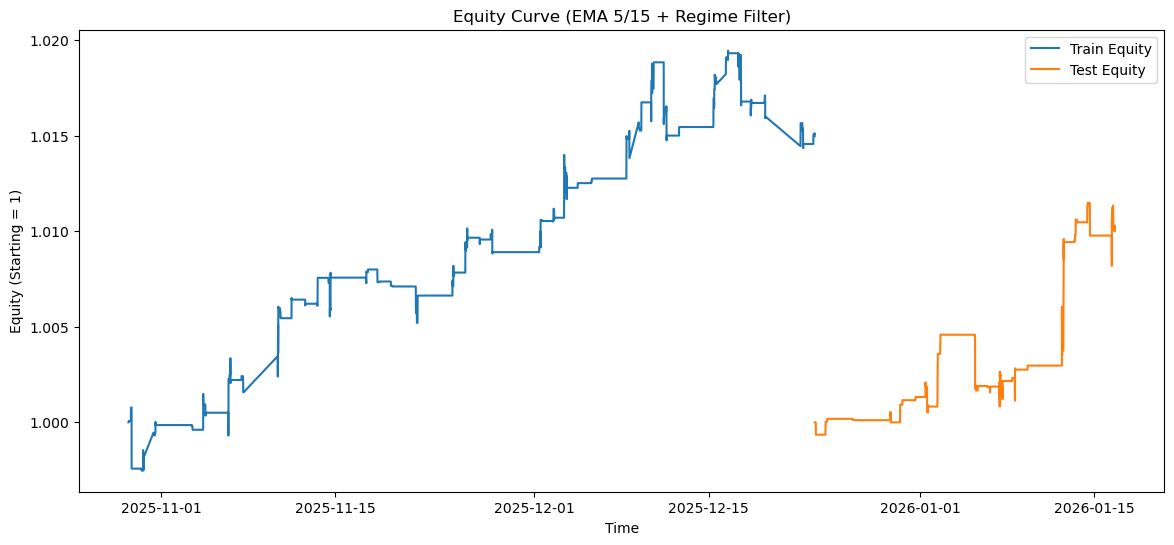

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train_df["timestamp"], (1+train_df["strategy_ret"].fillna(0)).cumprod(), label="Train Equity")
plt.plot(test_df["timestamp"], (1+test_df["strategy_ret"].fillna(0)).cumprod(), label="Test Equity")
plt.title("Equity Curve (EMA 5/15 + Regime Filter)")
plt.xlabel("Time")
plt.ylabel("Equity (Starting = 1)")
plt.legend()
plt.show()

In [1]:
import os
import matplotlib.pyplot as plt

os.makedirs("plots", exist_ok=True)

# Save the last shown plot (equity comparison)
plt.savefig("plots/equity_comparison.png", dpi=200, bbox_inches="tight")
print("Saved: plots/equity_comparison.png")

Saved: plots/equity_comparison.png


<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import numpy as np
import os, joblib
from xgboost import XGBClassifier

# Load ML dataset (use your df_ml already made OR load from file)
df_ml = pd.read_csv("results_ml/ml_predictions_full.csv")
df_ml["timestamp"] = pd.to_datetime(df_ml["timestamp"])

# ---------------------------
# Create X and y
# ---------------------------
drop_cols = ["timestamp", "target"]
feature_cols = [c for c in df_ml.columns if c not in drop_cols]

X = df_ml[feature_cols].fillna(0)
y = df_ml["target"].astype(int)

# Train final XGBoost model
final_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss"
)

final_xgb.fit(X, y)

# Save model
os.makedirs("models", exist_ok=True)
joblib.dump(final_xgb, "models/xgboost_model.pkl")

print("✅ Saved: models/xgboost_model.pkl")

✅ Saved: models/xgboost_model.pkl
